In [1]:

import pandas as pd
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
import numpy as np

/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_states'
source_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb/2000/save/CKPT+2024-10-10+02-55-38+00/embedding_model.ckpt'
hparams_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb/2000/hyperparams.yaml'

# TalTech

In [4]:
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
import os
import sys
import speechbrain as sb

# TO DO: Append path (where your accent_id folder is (the one with the inference.py file))
# Otherwise you will get error:
sys.path.append("/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id")
from hyperpyyaml import load_hyperpyyaml

from inference import AccID_inf
from inference import return_embedding
from inference import dataio_prep

classifier = WaveformEncoder.from_hparams(source=source_path, hparams_file=hparams_path)
hparams_file = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/hparams/inference_ecapa_tdnn_at_states.yaml"
# hparams_file = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/hparams/inference_ecapa_tdnn.yaml" 
run_opts, overrides = {}, {}
overrides = {"output_folder": "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id"}
print(hparams_file)
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

accent_encoder = sb.dataio.encoder.CategoricalEncoder()

# Load label encoder (with multi-GPU DDP support)
# Please, take a look into the lab_enc_file to see the label to index
# mapping.
accent_encoder_file = os.path.join(hparams["pretrained_path"], "accent_encoder.txt")
accent_encoder.load_or_create(
    path=accent_encoder_file,
    output_key="accent",
)

# Create dataset objects "train", "dev", and "test" and accent_encoder
datasets = dataio_prep(hparams)

# Fetch and load pretrained modules
sb.utils.distributed.run_on_main(hparams["pretrainer"].collect_files)
# hparams["pretrainer"].load_collected(device=run_opts["device"])

# Initialize the Brain object to prepare for performing inference.
accid_brain = AccID_inf(
    modules=hparams["modules"],
    hparams=hparams,
)
accid_brain.eval()

def get_embedding(file_path):
    embedding = return_embedding(file_path, accid_brain, save_path=None)
    # print("Embedding shape: ", embedding.shape)
    pooling_layer = StatisticsPooling(return_std=False)
    # print("Pooling layer: ", pooling_layer)
    # embedding = pooling_layer(embedding).squeeze().cpu().numpy()
    embedding = pooling_layer(embedding).detach().squeeze().cpu().numpy()
    # print("Embedding shape after pooling: ", embedding.shape)
    return embedding


# experimental testing for 1 file:
# file_path = "/lorenz/.cache/huggingface/datasets/downloads/extracted/7fa940d5e98e14130c923c2dde203c1729e46a596f788672e3580c0dece79a25/de_train_0/common_voice_de_27341092.mp3"
file_path = '/home/projects/vokquant/data/dicla/processed_16khz_renamed/MS_WJ/70516_MS_WJ_436.01.wav'
embedding = get_embedding(file_path)
print("Embedding shape: ", embedding.shape)

/home/projects/vokquant/accent-recog-slt2022/CommonAccent/accent_id/hparams/inference_ecapa_tdnn_at_states.yaml
Embedding shape:  (192,)


# MMS embedding

In [9]:
from transformers import Wav2Vec2ForSequenceClassification, AutoFeatureExtractor
import torch
import soundfile as sf

# Load the model and processor once
model_id_mms = "facebook/mms-lid-4017"
processor_mms = AutoFeatureExtractor.from_pretrained(model_id_mms)
model_mms = Wav2Vec2ForSequenceClassification.from_pretrained(model_id_mms)

def get_embedding_mms(audio_file, model, processor):
    # Load audio file
    speech, sample_rate = sf.read(audio_file)

    # Process the audio using the feature extractor
    # if stereo, use only one channel
    if len(speech.shape) > 1:
        speech = speech[:, 0]
    inputs = processor(speech, sampling_rate=sample_rate, return_tensors="pt", padding=True)

    # Forward pass through the model to get both logits and hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract the logits for language identification
    logits = outputs.logits

    # Get the predicted language
    lang_id = torch.argmax(logits, dim=-1)[0].item()
    detected_lang = model.config.id2label[lang_id]

    # Extract the embeddings from the last hidden state
    embeddings = outputs.hidden_states[-1]

    # Optionally, calculate mean embeddings if you need a single vector per input
    mean_embeddings = torch.mean(embeddings, dim=1)

    # Return the detected language and embeddings
    return detected_lang, mean_embeddings

Some weights of the model checkpoint at facebook/mms-lid-4017 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.layers.41.adapter_layer.linear_1.weight', 'wav2vec2.encoder.layers.16.adapter_layer.linear_2.bias', 'wav2vec2.encoder.layers.3.adapter_layer.linear_1.bias', 'wav2vec2.encoder.layers.18.adapter_layer.linear_1.weight', 'wav2vec2.encoder.layers.3.adapter_layer.linear_2.bias', 'wav2vec2.encoder.layers.32.adapter_layer.linear_1.bias', 'wav2vec2.encoder.layers.45.adapter_layer.linear_2.weight', 'wav2vec2.encoder.layers.35.adapter_layer.norm.bias', 'wav2vec2.encoder.layers.25.adapter_layer.norm.bias', 'wav2vec2.encoder.layers.41.adapter_layer.linear_1.bias', 'wav2vec2.encoder.layers.44.adapter_layer.linear_2.weight', 'wav2vec2.encoder.layers.1.adapter_layer.linear_2.bias', 'wav2vec2.encoder.layers.6.adapter_layer.linear_1.weight', 'wav2vec2.encoder.layers.4.adapter_layer.norm.weight', 'wav2vec2.encoder.layers.20.adapter_layer.linear_1.bias', 'wav2

In [10]:
# Usage of the function
audio_file = "/home/projects/vokquant/fairseq/audio_samples/de.wav"  # Path to the audio file

detected_language, embeddings = get_embedding_mms(audio_file, model_mms, processor_mms)

print(f"Detected language: {detected_language}")
print("Embeddings shape:", embeddings.shape)

Detected language: deu
Embeddings shape: torch.Size([1, 1280])


In [6]:
# read test items
test_items = pd.read_csv(f'{test_path}/dev.csv')
embeddings = []
accents = []

output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb"
save_path = os.path.join(output_folder, "embeddings")

# go through all test items and get embeddings
for index, row in test_items.iterrows():
    # filepath = f"{test_path}/test/{row['utt_id']}.wav"
    filepath = f"{row['wav']}"
    # filename = test_items.iloc[index].utt_id #filepath.split("/")[-1].replace(".wav", ".npy").replace(".mp3", ".npy")
    emb = get_embedding(filepath)    
    accent = row['accent']
    embeddings.append(emb)
    accents.append(accent)

embeddings = np.array(embeddings)
print("Embeddings shape: ", np.shape(embeddings))
print("Accents shape: ", np.shape(accents))

# def generate_embeddings(csv_path, save_path):
#     test_items = pd.read_csv(csv_path)
#     embeddings = []
#     accents = []

#     # go through all test items and get embeddings
#     for index, row in test_items.iterrows():
#         filepath = f"{row['wav']}"
#         emb = get_embedding(filepath)    
#         accent = row['accent']
#         embeddings.append(emb)
#         accents.append(accent)

#     embeddings = np.array(embeddings)
#     print("Embeddings shape: ", np.shape(embeddings))
#     print("Accents shape: ", np.shape(accents))
#     return embeddings, accents

# output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb"
# save_path = os.path.join(output_folder, "embeddings")
# embedding, accents = generate_embeddings(f'{test_path}/test.csv', save_path)

Embeddings shape:  (3018, 192)
Accents shape:  (3018,)


# Using T-SNE for 2D plotting

In [6]:
# Easier to understand but less elegant way:
# print(stacked_accent)
# print unique
# unique_classes = np.unique(accents)
# print("Unique accents: ", unique_classes)

# emb_ungarisch = []
# emb_griechisch = []
# emb_kanadisch = []
# emb_britisch = []
# emb_ruhrpott = []
# emb_russisch = []
# emb_amerikanisch = []

# # fill the lists with the embeddings
# for i in range(len(accents)):
#     if accents[i] == "UNGARISCH DEUTSCH":
#         emb_ungarisch.append(embeddings[i])
#     elif accents[i] == "GRIECHISCH DEUTSCH":
#         emb_griechisch.append(embeddings[i])
#     elif accents[i] == "KANADISCHES DEUTSCH":
#         emb_kanadisch.append(embeddings[i])
#     elif accents[i] == "BRITISCHES DEUTSCH":
#         emb_britisch.append(embeddings[i])
#     elif accents[i] == "RUHRPOTT DEUTSCH":
#         emb_ruhrpott.append(embeddings[i])
#     elif accents[i] == "RUSSISCH DEUTSCH":
#         emb_russisch.append(embeddings[i])
#     elif accents[i] == "AMERIKANISCHES DEUTSCH":
#         emb_amerikanisch.append(embeddings[i])
#     else:
#         print("Error: ", accents[i])


# # print statistics
# print("Ungarisch: ", len(emb_ungarisch))
# print("Griechisch: ", len(emb_griechisch))
# print("Kanadisch: ", len(emb_kanadisch))
# print("Britisch: ", len(emb_britisch))
# print("Ruhrpott: ", len(emb_ruhrpott))
# print("Russisch: ", len(emb_russisch))
# print("Amerikanisch: ", len(emb_amerikanisch))

# import matplotlib.pyplot as plt
# import matplotlib
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=0)
# emb_amerikanisch = np.array(emb_amerikanisch)
# emb_britisch = np.array(emb_britisch)
# emb_griechisch = np.array(emb_griechisch)
# emb_kanadisch = np.array(emb_kanadisch)
# emb_ruhrpott = np.array(emb_ruhrpott)
# emb_russisch = np.array(emb_russisch)
# emb_ungarisch = np.array(emb_ungarisch)

# lab_amerikanisch = np.zeros(len(emb_amerikanisch))
# lab_britisch = np.ones(len(emb_britisch))
# lab_griechisch = np.full(len(emb_griechisch), 2)
# lab_kanadisch = np.full(len(emb_kanadisch), 3)
# lab_ruhrpott = np.full(len(emb_ruhrpott), 4)
# lab_russisch = np.full(len(emb_russisch), 5)
# lab_ungarisch = np.full(len(emb_ungarisch), 6)

# # concatenate the embeddings and the labels in this order AMERIKANISCHES DEUTSCH' 'BRITISCHES DEUTSCH' 'GRIECHISCH DEUTSCH' 'KANADISCHES DEUTSCH' 'RUHRPOTT DEUTSCH' 'RUSSISCH DEUTSCH' 'UNGARISCH DEUTSCH']
# X = np.concatenate((emb_amerikanisch, emb_britisch, emb_griechisch, emb_kanadisch, emb_ruhrpott, emb_russisch, emb_ungarisch))
# y = np.concatenate((lab_amerikanisch, lab_britisch, lab_griechisch, lab_kanadisch, lab_ruhrpott, lab_russisch, lab_ungarisch))

# print("len(ungarisch): ", len(emb_ungarisch))
# X_embedded = tsne.fit_transform(X)
# print("X_embedded shape: ", np.shape(X_embedded))

# # plot the embeddings
# plt.figure(figsize=(10, 10))
# colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow']
# for i, label in enumerate(unique_classes):
#     plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=colors[i], label=label)
# plt.legend()
# plt.show()


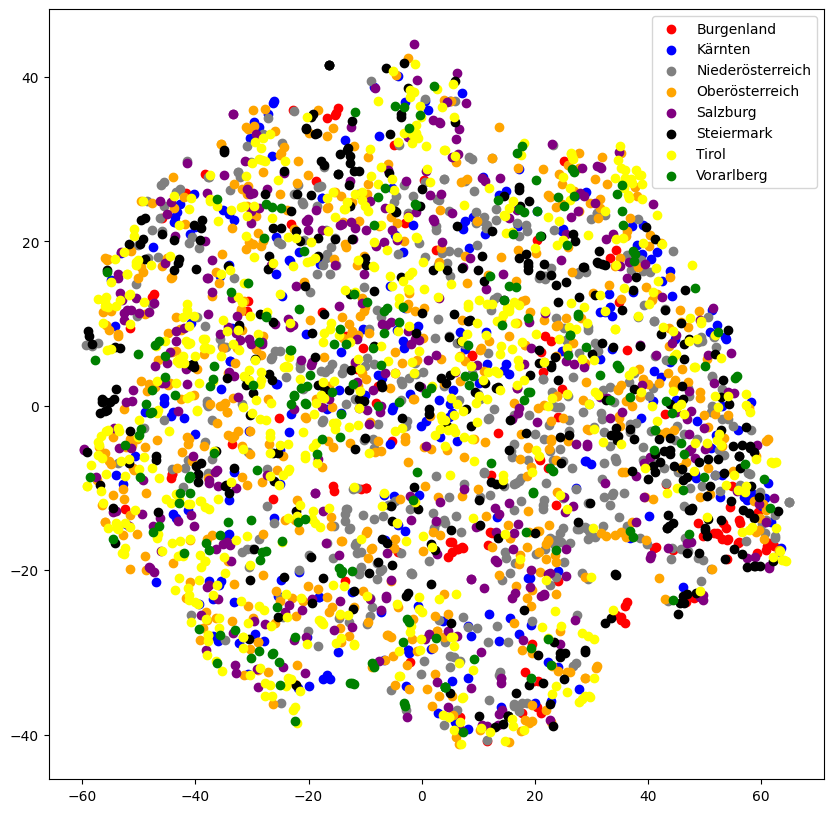

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a dictionary to store embeddings for each class
emb_dict = {cls: [] for cls in np.unique(accents)}

# Fill the dictionary with embeddings
for accent, emb in zip(accents, embeddings):
    emb_dict[accent].append(emb)

# Convert the dictionary values to numpy arrays
for cls in emb_dict:
    emb_dict[cls] = np.array(emb_dict[cls])

# Create labels for each class
label_dict = {cls: i*np.ones(len(emb_dict[cls])) for i, cls in enumerate(emb_dict)}

# Concatenate embeddings and labels
X = np.concatenate(list(emb_dict.values()))
y = np.concatenate(list(label_dict.values()))

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# number 1 is for Burgenland, 2 for Kärnten, 3 for Niederösterreich, 4 for Oberösterreich, 5 for Salzburg, 6 for Steiermark, 7 for Tirol, 8 for Vorarlberg
classes = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich', 'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg']

# Plot the embeddings
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
for i, (cls, emb) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=colors[i], label=classes[i])  # Use classes[i] as label

# Add the legend with class names
plt.legend()
plt.show()


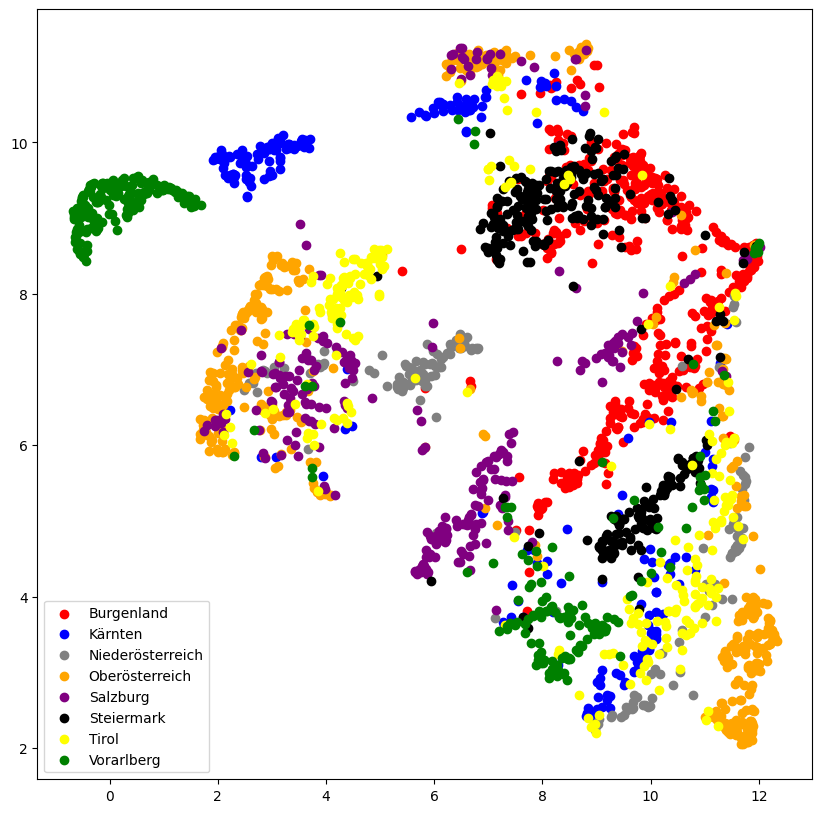

In [7]:
import umap.umap_ as umap

# Instantiate UMAP
umap_model = umap.UMAP(n_components=2, random_state=0)
X_embedded_umap = umap_model.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
for i, (cls, emb) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded_umap[y == i, 0], X_embedded_umap[y == i, 1], c=colors[i], label=classes[i])  # Use classes[i]
plt.legend()
plt.show()


# MMS compute embs

In [11]:
import os
from tqdm import tqdm
import pickle

# read test items
test_items = pd.read_csv(f'{test_path}/test.csv')
embeddings_mms = []
accents = []

output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb"
save_path = os.path.join(output_folder, "embeddings")

# go through all test items and get embeddings
for index, row in tqdm(test_items.iterrows()):
    if index % 5 != 0:
        continue
    else:
        # filepath = f"{test_path}/test/{row['utt_id']}.wav"
        filepath = f"{row['wav']}"
        filename = test_items.iloc[index].utt_id #filepath.split("/")[-1].replace(".wav", ".npy").replace(".mp3", ".npy")
        lang, emb_mms = get_embedding_mms(filepath, model_mms, processor_mms)    
        accent = row['accent']
        embeddings_mms.append(emb_mms)
        accents.append(accent)

with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_mms.pkl"), "wb") as f:
    pickle.dump(embeddings_mms, f)

# embeddings_mms = np.array(embeddings_mms)
print("Embeddings shape: ", np.shape(embeddings_mms))
print("Accents shape: ", np.shape(accents))

2598it [03:37, 11.97it/s]

Embeddings shape:  (520, 1, 1280)
Accents shape:  (520,)


In [14]:
print((embeddings_mms))
# make each tensor to numpy array
embeddings_mms = [emb.numpy() for emb in embeddings_mms]

[tensor([[ 0.8310, -0.6110, -0.5718,  ..., -0.3967, -0.7620, -0.1645]]), tensor([[ 0.4585,  0.2975, -0.3038,  ..., -0.4901, -1.3737,  0.1783]]), tensor([[ 0.4983,  0.2603, -0.2459,  ..., -0.4645, -1.0204,  0.8177]]), tensor([[ 1.5102,  0.0585, -0.7733,  ..., -0.5686,  0.2620,  0.8546]]), tensor([[ 0.1845, -0.1615, -0.2160,  ..., -0.0873, -1.0490,  0.1612]]), tensor([[ 0.5374,  0.1583, -0.2416,  ..., -0.4235, -0.8497,  0.8717]]), tensor([[ 0.1835,  1.1796, -0.0641,  ..., -0.6207, -1.7821,  1.2246]]), tensor([[ 1.2322, -0.5461, -0.7657,  ..., -0.8850, -0.3184,  0.7327]]), tensor([[ 0.5918,  0.4313, -0.3851,  ..., -0.1790, -1.0481,  0.3805]]), tensor([[ 1.2690, -0.3193, -0.3175,  ..., -0.5220, -0.1303,  1.1305]]), tensor([[ 1.3913e+00, -4.0115e-01, -8.0028e-01,  ..., -6.0670e-01,
         -8.2510e-04,  9.8176e-01]]), tensor([[ 0.5512, -0.5434, -0.4005,  ..., -0.1616, -0.2650,  1.1734]]), tensor([[-0.3959, -0.7470, -0.1667,  ...,  0.0152, -0.6976,  1.0043]]), tensor([[ 0.0333, -0.2628,  0.

In [16]:
# array = []
# for x in embeddings_mms:
#     print(x[1].shape)
#     array.append(x[1])
embeddings_mms2 = np.array([x for x in embeddings_mms])
# print(embeddings_mms2)
# print(embeddings_mms[0][1].shape)
# embeddings_mms2 = embeddings_mms[:, 1]

# embeddings_mms2 = np.array(embeddings_mms2)
print("Embeddings shape: ", np.shape(embeddings_mms2))
print("Accents shape: ", np.shape(accents))

# squeeze middle dimension
embeddings_mms3 = np.squeeze(embeddings_mms2, axis=1)
print("Embeddings shape: ", np.shape(embeddings_mms3))

Embeddings shape:  (260, 1, 1280)
Accents shape:  (260,)
Embeddings shape:  (260, 1280)


# MMS visualization

In [20]:
# import umap.umap_ as umap

# # Instantiate UMAP
# umap_model = umap.UMAP(n_components=2, random_state=0)
# X_embedded_umap = umap_model.fit_transform(X)

# # Plot the embeddings
# plt.figure(figsize=(10, 10))
# colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
# for i, (cls, emb_mms) in enumerate(emb_dict.items()):
#     plt.scatter(X_embedded_umap[y == i, 0], X_embedded_umap[y == i, 1],
#                 c=colors[i],
#                 label=classes[i])  # Use classes[i]
# plt.legend()
# plt.show()

Speech shape:  (282560,)
Sample rate:  16000


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a dictionary to store embeddings for each class
emb_dict = {cls: [] for cls in np.unique(accents)}

# Fill the dictionary with embeddings
for accent, emb in zip(accents, embeddings_mms3):
    emb_dict[accent].append(emb)

# Convert the dictionary values to numpy arrays
for cls in emb_dict:
    emb_dict[cls] = np.array(emb_dict[cls])

# Create labels for each class
label_dict = {cls: i*np.ones(len(emb_dict[cls])) for i, cls in enumerate(emb_dict)}

# Concatenate embeddings and labels
X = np.concatenate(list(emb_dict.values()))
y = np.concatenate(list(label_dict.values()))

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


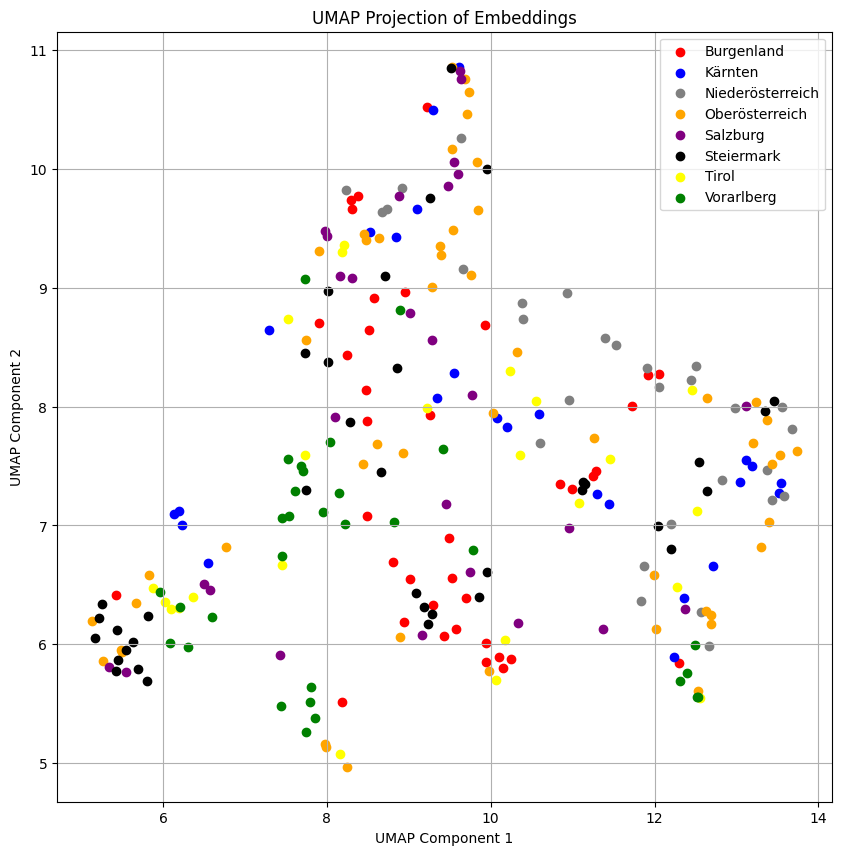

In [20]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Instantiate UMAP
umap_model = umap.UMAP(n_components=2, random_state=0)
X_embedded_umap = umap_model.fit_transform(X)

classes = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich', 'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg']

# Define marker styles
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']  # Circle, square, diamond, triangle up, triangle down, plus, star, X
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']

# Plot the embeddings
plt.figure(figsize=(10, 10))
for i, (cls, embeddings_mms3) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded_umap[y == i, 0], X_embedded_umap[y == i, 1], 
                c=colors[i], label=classes[i], 
                # marker=markers[i % len(markers)],  # Use different markers
                # alpha=0.6,  # Add transparency
                # edgecolor='k',
                )  # Add a black edge color for better visibility

plt.title('UMAP Projection of Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


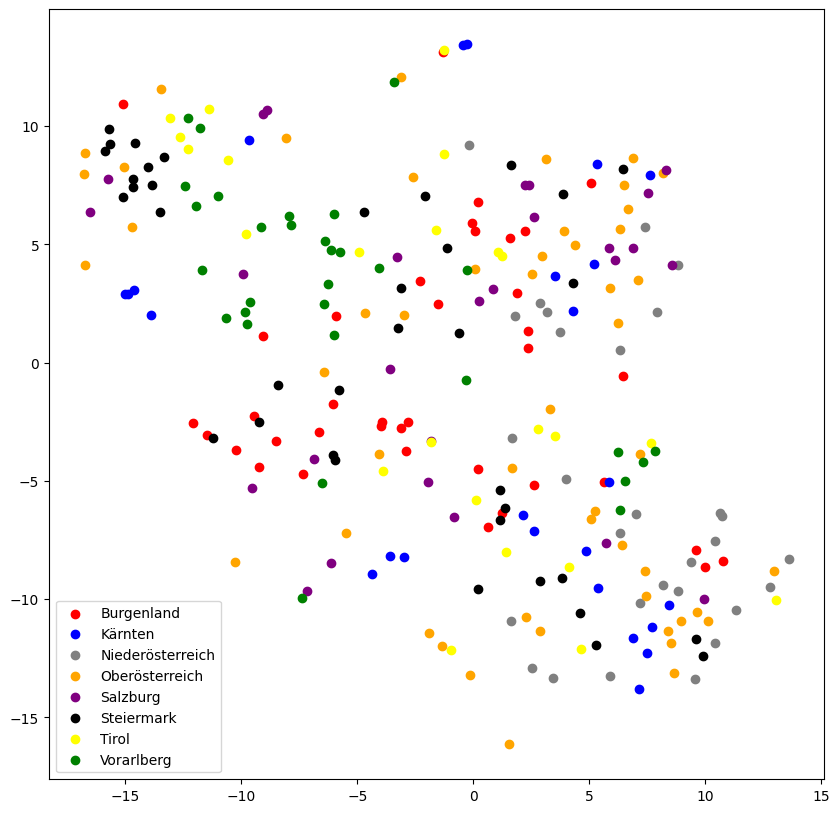

In [21]:
# make for tsne
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
for i, (cls, emb) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=colors[i], label=classes[i])  # Use classes[i] as label

# Add the legend with class names
plt.legend()
plt.show()

